<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2021 Reduction Exercise: Part 3</h2>

We are going to be aligning the images a different way than what I outlined in class because the data we have were causing problems with the automatic routine to calculate the shift in pixels between images and doing it would have involved a lot of hands on entry of coordinates that would have taken too long.  Instead we will be using astrometry.net to find the WCS for each image and will be using that info, which tells us what (RA,DEC) corresponds to each (x,y), to align the images using another task.  It works just as well as what I described in class, but is different in detail.

In this part you will do the following steps
* copy image names and trim files to get rid of vignetted section of detector

* Use astrometry.net functions to find the WCS for each image

* Use that WCS to align each image

* combine each set of aligned images into a final image.

* fix an remaining NaN's around the edges of the images that were a result of the combination process

* subtract the background from each image and then display them.

There are only three elements where you need to write your answer.  The rest of the work is just making sure all of the steps carry out successfully and that images are produced at the end.

**This is due on Monday Nov. 22**

In [1]:
import os
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.visualization import simple_norm
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import scoreatpercentile
import glob
import time
import multiprocessing as mp
import ccdproc

## Fixing the Header Information

* When we took the data for Markarian 50, the FLI Pilot forgot to connect MaxIm DL to the telescope.  As a result, we do not have information about where the telescope was pointed.

* Astronomy.net works better if we provide information on the approximate RA and DEC of the image so it knows where in the sky to search for matching triangles

* Therefore, we will add the RA and DEC for Markarian 50 to the header by hand using the function fixheader.

In [2]:
def fixheader(filelist,ra=None,dec=None,rakeyword='OBJCTRA',deckeyword='OBJCTDEC'):
  ''' update the RA and DEC in image header; useful if telescope is not connected to maxImDL '''
  print('got ',len(filelist),' files to update')
  if ra is not None:
      for f in filelist:
        data,header = fits.getdata(f,header=True)
        header.set(rakeyword,ra)
        fits.writeto(f,data,header,overwrite=True)
  if dec is not None:
      for f in filelist:
        data,header = fits.getdata(f,header=True)
        header.set(deckeyword,dec)
        fits.writeto(f,data,header,overwrite=True)

## Copy image names and trim images to remove vignetted section.

* To make it easier to code later, I am renaming all the dark subtracted and flat-fielded science files to put their band (g or r) at the end

* I am also trimming them to remove the vignetted region

In [6]:
from shutil import copyfile

#this changes to the directory of our images
redpath = "/home/y731z863/ASTR596/JNB/ObservingProject/Reduced/"
os.chdir(redpath)

#to make the code work better later on, executing this code will rename our 
#science images to have the filter name in the image name
#!cp s009df.fit s009df_g.fit

for i in range(9,15):   
    if(i==9):
        fsource = redpath + 's00' + str(i) + 'df.fit'
    else:
        fsource = redpath + 's0' + str(i) + 'df.fit'
    ftarg = fsource.replace('df.fit','df_g.fit',1)
    copyfile(fsource,ftarg)

    #now trim the target images to get rid of the vignetted sections
    ftrim = ftarg.replace('df_g.fit','dft_g.fit',1)
    img, hdr = fits.getdata(ftarg, header=True)
    img2 = img[0:1670, 0:1480]
    fits.writeto(ftrim, img2, header=hdr, overwrite=True)
    
for i in range(15,21):   
    fsource = redpath + 's0' + str(i) + 'df.fit'
    ftarg = fsource.replace('df.fit','df_r.fit',1)
    copyfile(fsource,ftarg)

    #now trim the target images to get rid of the vignetted sections
    ftrim = ftarg.replace('df_r.fit','dft_r.fit',1)
    img, hdr = fits.getdata(ftarg, header=True)
    img2 = img[0:1670, 0:1480]
    fits.writeto(ftrim, img2, header=hdr, overwrite=True)


In [7]:
# get coords of Markarian 50
#ra = '23 15 18'
#dec = '+60 28 00'
ra = '22 28 00'
dec = '+59 11 16'
#this writes all of the files matching the expresion to a file

#the glob.glob function puts all the files in your directory that match the string
#and puts them into a python list
mark50_zfilelist = glob.glob('s0*dft*.fit')
fixheader(mark50_zfilelist,ra=ra,dec=dec)

got  12  files to update


## Define Display function

In [19]:
def display_image(imagename,cmap='viridis',p1=5,p2=99.5,stretch='asinh'):
 
  d = fits.getdata(imagename)
  a = scoreatpercentile(d,p1)
  b = scoreatpercentile(d,p2)
  norm = simple_norm(d,min_percent=p1,max_percent=p2)  
  #plt.figure(figsize=(12,10))
  plt.imshow(d,vmin=a,vmax=b,cmap=cmap,norm=norm)

## Define Some Photometry Functions

* these are functions that we will use when measuring the background in an image, or for identifying sources in the image.
* you don't need to worry about the details of what each is doing at this point, unless of course you want to!

In [8]:
def get_sky_background(img, verbose=False):
    from astropy.stats import sigma_clipped_stats
    # estimate background counts in image
    mean, median, std = sigma_clipped_stats(img, sigma=3.0)
    
    return median,std

def find_stars(img, fwhm=3.0, nsigma=5, verbose=False):
    from photutils import DAOStarFinder

    bkg,sigma = get_sky_background(img, verbose=verbose)
    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
    srcs = daofind(img - bkg)
    if verbose:
        print('Found {} stars'.format(len(srcs)))    
    return srcs

def get_panstarrs_catalog(imgwcs, radius=0.2, verbose=False):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    from astroquery.mast import Catalogs

    ra0, dec0 = imgwcs.wcs.crval
    coords = SkyCoord(ra0, dec0, unit=u.deg, frame='icrs')
    
    if verbose:
        print('Querying Pan-STARRS {:.3f} deg around RA, Dec={:.5f}, {:.5f} '.format(radius, ra0, dec0))
        
    cat = Catalogs.query_criteria(coordinates=coords, radius=radius,
                                  catalog='PANSTARRS', data_release='dr2', 
                                  table='mean',
                                  columns=['objID', 'raMean', 'decMean',
                                           'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                           gMeanPSFMag=[('lte', 18), ('gte', 8)],
                                           rMeanPSFMag=[('lte', 18), ('gte', 8)],
                                           iMeanPSFMag=[('lte', 18), ('gte', 8)],
                                           zMeanPSFMag=[('lte', 18), ('gte', 8)])
                                           #sort_by=[("asc", "rMeanPSFMag")]

    # http://legacysurvey.org/dr8/description/#photometry
    gi = cat['gMeanPSFMag'] - cat['iMeanPSFMag']
    keep = np.where( (gi > 0.4) * (gi < 2.7) )[0]
    cat = cat[keep]
    
    return cat


## Find the astrometric solutions for each of your images

The following steps will do the following:

* Compile a list of all the images

* run the astrometry_wrapper to detect sources in your image using the find_stars function, and then send that list to astrometry.net to find the astrometric solution.  This then writes out a new image with the correct WCS in the header.

For this next step you'll need your astrometry.net API key, which you can find at this site http://nova.astrometry.net/api_help.  You will need to get an account on this site and can use the Github authentication in the login process as all of you have Github accounts.  

Please do not use my API key!

## Astrometry functions

Put your API key in the first line of this program.

In [9]:
def get_astrometry(imgfile, srcs=None, api_key='vqxyqzhcdadixsgk', prefix='w', overwrite=True): # please dont use my key

    from astropy.io import fits
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    from astroquery.astrometry_net import AstrometryNet  
    reduxdir = os.getcwd()
    wcsfile = os.path.join(reduxdir, '{}{}'.format(prefix, os.path.basename(imgfile)))
    if not os.path.isfile(wcsfile) or overwrite:
        img, hdr = fits.getdata(imgfile, header=True)

        # Initialize the API.
        ast = AstrometryNet()
        if api_key:
            ast.api_key = api_key
        #ast.show_allowed_settings()

        # Get the initial position center based on the header.
        c = SkyCoord(hdr['OBJCTRA']+hdr['OBJCTDEC'], unit=(u.hourangle, u.deg))
        print('Initial RA, Dec = {:.5f}, {:.5f}'.format(c.ra.value, c.dec.value))

        # Query the astrometry.net engine!
        t0 = time.time()
        wcshdr = ast.solve_from_source_list(
            srcs['xcentroid'], srcs['ycentroid'], hdr['naxis1'], hdr['naxis2'],
            center_ra=c.ra.value, center_dec=c.dec.value, radius=15/60.0, 
            scale_type='ev', scale_est=0.8, scale_err=10, scale_units='arcsecperpix',
            crpix_center=True)
        print('Total time = {:.3f} min'.format((time.time() - t0)/60))

        # update the original header
        for key in wcshdr.keys():
            if key not in hdr and key != 'COMMENT' and key != 'HISTORY':
                hdr[key] = wcshdr[key]

        print('Writing {}'.format(wcsfile))
        fits.writeto(wcsfile, img, header=wcshdr, overwrite=True)        
    else:
        wcshdr = fits.getheader(wcsfile)

    return wcsfile, wcshdr

In [10]:
def astrometry_wrapper(filelist):
  for f in filelist:
    # read in image
    imdata = fits.getdata(f)
    # get sources by detecting them in the image
    source_cat = find_stars(imdata)
    #display(source_cat)
    
    # call astrometry
    get_astrometry(f,srcs=source_cat,overwrite=True)

    #break

In [11]:
#testfilelist = glob.glob('test.fit')
#fixheader(testfilelist,ra=ra,dec=dec)

# NOTE: this is going to take a long time, like 1-2 min per image!
filelist = glob.glob('s0*dft_?.fit')
#filelist = glob.glob('s009df_g.fit')
print(filelist)


['s019dft_r.fit', 's020dft_r.fit', 's013dft_g.fit', 's017dft_r.fit', 's011dft_g.fit', 's009dft_g.fit', 's016dft_r.fit', 's012dft_g.fit', 's010dft_g.fit', 's018dft_r.fit', 's015dft_r.fit', 's014dft_g.fit']


This code below outputs a file that has a "w" at the beginning, to indicate that it has the correct WCS in the header

In [17]:
# NOTE: this is going to take a long time, like 1-2 min per image!
astrometry_wrapper(filelist)


Initial RA, Dec = 337.00000, 59.18778
Solving................................................................Total time = 1.149 min
Writing /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/ws019dft_r.fit
Initial RA, Dec = 337.00000, 59.18778
Solving........................................................................................Total time = 1.572 min
Writing /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/ws020dft_r.fit
Initial RA, Dec = 337.00000, 59.18778
Solving................................................................................Total time = 1.428 min
Writing /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/ws013dft_g.fit
Initial RA, Dec = 337.00000, 59.18778
Solving........................................................................................Total time = 1.579 min
Writing /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/ws017dft_r.fit
Initial RA, Dec = 337.00000, 59.18778
Solving...............................................................

## Problem 1: You need to describe how you can check whether the WCS is consistent among all the images

* You should go into DS9 and open up the images each into their own frame 
* using the "frame->match->WCS" menu list item, you can check if the images are aligned
* Describe how you would quantitatively check if the images' WCS are such that identical sources have the same RA and DEC.  I am not expecting you to do this check (though you certainly can), I am merely asking you to describe the process.

Write your answer in the blank cell below

**answer here**: 

Open up all the image frames in DS9, and "blink" all the frames. You can clearly see the images are the same with a little shift in x- and y-direction. To check if they all have the correct RA and DEC values, move the mouse onto some bright stars and check their physical x and y values. For the star on the right-bottom corner as an example, except for images 019 and 020, all the other iamges have the same RA and DEC values, which are 22:27 and +59:10 respectively. Similar check can be done using different stars. 

## Stack images

In [3]:
from reproject import reproject_interp
from astropy.wcs import WCS
from astropy.io import fits

##  Align a stack of Images

* reproject ALL images onto one reference image.  It chooses the first image in the input list as the reference and then uses the WCS in the header to shift all the images onto the same grid
* take average of all r-band images
* take average of all g-band images
* make color image using average r, average g, and average g



In [4]:
def wcs_align(file_list):
  '''
  GOAL: align images using wcs and combine the output

  INPUT: 
  * file_list : list of image to combine
  * outimage_filename : the name of the combined image 

  OUTPUT:
  * "s"+filename : the shifted version of each image is saved
  * the combined image
  '''
  # use the first image in the list as the reference
  refimage = file_list[0]
  hdu_ref = fits.open(file_list[0])[0]
  shifted_images = []
  for i,f in enumerate(file_list):
    print('REPROJECTING IMAGE {} OUT OF {}'.format(i+1,len(file_list)))
    hdu_next = fits.open(f)[0]
    reproject_image, footprint = reproject_interp(hdu_next, hdu_ref.header)
    # write out shifted image
    fits.writeto("s"+f,reproject_image,hdu_ref.header,overwrite=True)
    shifted_images.append("s"+f)

def combine_images(shifted_images,outimage_filename):
  if os.path.exists(outimage_filename):
    os.remove(outimage_filename)
  avg_combined = ccdproc.combine(shifted_images,output_file=outimage_filename,method='average',unit=u.electron,sigma_clip=True,sigma_clip_high_thresh=2.5,sigma_clip_low_thresh=2)
  #fits.writeto(outimage_filename, avg_combined, overwrite=True) 



In [8]:
# use glob to grab all the trimmed science files with the correct WCS
files_2align = glob.glob('w*dft*.fit')
print(files_2align)

['ws012dft_g.fit', 'ws015dft_r.fit', 'ws010dft_g.fit', 'ws014dft_g.fit', 'ws013dft_g.fit', 'ws020dft_r.fit', 'ws016dft_r.fit', 'ws018dft_r.fit', 'ws011dft_g.fit', 'ws019dft_r.fit', 'ws009dft_g.fit', 'ws017dft_r.fit']


Now use the WCS to align the images.  In this case the alignment comes only from a shift

In [9]:
%%time
wcs_align(files_2align)

REPROJECTING IMAGE 1 OUT OF 12
REPROJECTING IMAGE 2 OUT OF 12
REPROJECTING IMAGE 3 OUT OF 12
REPROJECTING IMAGE 4 OUT OF 12
REPROJECTING IMAGE 5 OUT OF 12
REPROJECTING IMAGE 6 OUT OF 12
REPROJECTING IMAGE 7 OUT OF 12
REPROJECTING IMAGE 8 OUT OF 12
REPROJECTING IMAGE 9 OUT OF 12
REPROJECTING IMAGE 10 OUT OF 12
REPROJECTING IMAGE 11 OUT OF 12
REPROJECTING IMAGE 12 OUT OF 12
CPU times: user 58.8 s, sys: 6.57 s, total: 1min 5s
Wall time: 1min 5s


## Problem 2: You need to describe how you can check whether the images were aligned properly

* You should go into DS9 and open up the images each into their own frame 
* using the "frame->match->image" menu list item, you can blink the images to check if they look aligned.  Describe what your conclusions are.
* Describe how you would quantitatively check if the images are actually aligned.  I am not expecting you to do this check (though you certainly can), I am merely asking you to describe the process.

Write your answer in the blank cell below

**answer here**: 
When I blink through all the images, all the stars remain in the same position, while you can see a shift on the background, which indicates that the pixels that detected stars are all aligned. 
Compare each image's physical and image value on x- and y-direction. The values should be the same on their coordinates. 

## Now combine the images

In [10]:
%%time
goutimage_filename = 'mark50g-stacked.fit'
gshifted_filenames = glob.glob('sws*dft_g.fit')
if os.path.exists(goutimage_filename):
  os.remove(goutimage_filename)
combine_images(gshifted_filenames,goutimage_filename)

CPU times: user 1.02 s, sys: 597 ms, total: 1.61 s
Wall time: 1.62 s


In [11]:
%%time
routimage_filename = 'mark50r-stacked.fit'
rshifted_filenames = glob.glob('sws*dft_r.fit')
if os.path.exists(routimage_filename):
  os.remove(routimage_filename)
combine_images(rshifted_filenames,routimage_filename)

CPU times: user 1.04 s, sys: 485 ms, total: 1.52 s
Wall time: 1.53 s


In [12]:
def readimage(filename):
    imgfile = os.path.join('{}'.format(redpath), filename)
    print('Reading {}'.format(imgfile))
    img, hdr = fits.getdata(imgfile, header=True)
    return img,hdr

This removes NaN's from around the edges of the image that resulted from the combination process

In [13]:
#fix NaN's in image
#g-band
img_mark50_g,hdr_g = readimage(goutimage_filename)
img_mark50_g_cl = np.nan_to_num(img_mark50_g)
goutimage_filename_cl = goutimage_filename.replace('stacked.fit','stacked-cl.fit',1)
fits.writeto(redpath + goutimage_filename_cl, img_mark50_g_cl, header=hdr_g, overwrite=True)

#r-band
img_mark50_r,hdr_r = readimage(routimage_filename)
img_mark50_r_cl = np.nan_to_num(img_mark50_r)
routimage_filename_cl = routimage_filename.replace('stacked.fit','stacked-cl.fit',1)
fits.writeto(redpath + routimage_filename_cl, img_mark50_r_cl, header=hdr_r, overwrite=True)


Reading /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/mark50g-stacked.fit
Reading /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/mark50r-stacked.fit


## Now subtract the background

This isn't really correct, as you will see a gradient in the combined image if you open them in ds9 (*you should do this*).  That gradient in the image was from flatfield problems that we aren't able to fix because the flatfield data we took had problems.  In practice, I should divide out the gradient before doing background subtraction but for the purposes of this exercise I'm going to treat the gradient in flux as a gradient in background. For now though this will at least produce better **looking** images, though likely not correct ones.

The code below computes the background by smoothing the image with a 75x75 boxcar filter.

In [14]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=3.)
    bkg = Background2D(img, (75,75), filter_size=(5, 5), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

In [15]:
#this reads the image in and then determines the background
#g-band
img_mark50_g_cl,hdr_g = readimage(goutimage_filename_cl)
bkg_g = get_sky_background(img_mark50_g_cl, verbose=True)

#r-band
img_mark50_r_cl,hdr_r = readimage(routimage_filename_cl)
bkg_r = get_sky_background(img_mark50_r_cl, verbose=True)


Reading /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/mark50g-stacked-cl.fit
Sky background median = 4831.874, rms = 21.557 electrons.
Reading /home/y731z863/ASTR596/JNB/ObservingProject/Reduced/mark50r-stacked-cl.fit
Sky background median = 4635.242, rms = 19.504 electrons.


In [16]:
#this subtracts the background from each band
img_mark50_g_cl_nosky = img_mark50_g_cl - bkg_g.background
img_mark50_r_cl_nosky = img_mark50_r_cl - bkg_r.background


In [17]:
#this writes out the background and background subtracted images to files with 
#the *bkg.fit and *bkgsub.fit extenstions.
#g-band
goutimage_filename_bkg = goutimage_filename_cl.replace('cl.fit','bkg.fit',1)
fits.writeto(goutimage_filename_bkg, bkg_g.background, header=hdr_g, overwrite=True)  
print(goutimage_filename_bkg)

goutimage_filename_bkgsub = goutimage_filename_bkg.replace('bkg.fit','bkgsub.fit',1)
print(goutimage_filename_bkgsub)
fits.writeto(goutimage_filename_bkgsub, img_mark50_g_cl_nosky, header=hdr_g, overwrite=True)        

#r-band
routimage_filename_bkg = routimage_filename_cl.replace('cl.fit','bkg.fit',1)
fits.writeto(routimage_filename_bkg, bkg_r.background, header=hdr_r, overwrite=True)  
print(routimage_filename_bkg)

routimage_filename_bkgsub = routimage_filename_bkg.replace('bkg.fit','bkgsub.fit',1)
print(routimage_filename_bkgsub)
fits.writeto(routimage_filename_bkgsub, img_mark50_r_cl_nosky, header=hdr_r, overwrite=True)        


mark50g-stacked-bkg.fit
mark50g-stacked-bkgsub.fit
mark50r-stacked-bkg.fit
mark50r-stacked-bkgsub.fit


/tmp/ipykernel_28344/460687799.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(d,vmin=a,vmax=b,cmap=cmap,norm=norm)


Text(0.5, 1.0, 'g-band background subtracted')

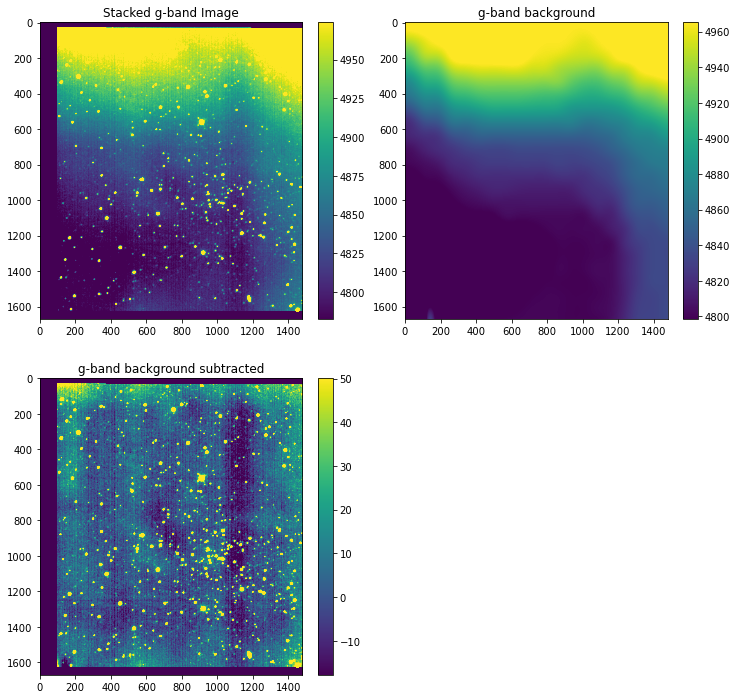

In [20]:
#displays the different g-band images
#%%time
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=.2)
plt.subplot(2,2,1)
display_image(goutimage_filename_cl,p1=20,p2=90)
plt.colorbar(fraction=.08)
plt.title('Stacked g-band Image')
plt.subplot(2,2,2)
display_image(goutimage_filename_bkg,p1=20,p2=90)
plt.colorbar(fraction=.08)
plt.title('g-band background')
plt.subplot(2,2,3)
display_image(goutimage_filename_bkgsub,p1=25,p2=95)
plt.colorbar(fraction=.08)
plt.title('g-band background subtracted')


/tmp/ipykernel_28344/460687799.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(d,vmin=a,vmax=b,cmap=cmap,norm=norm)


Text(0.5, 1.0, 'r-band background subtracted')

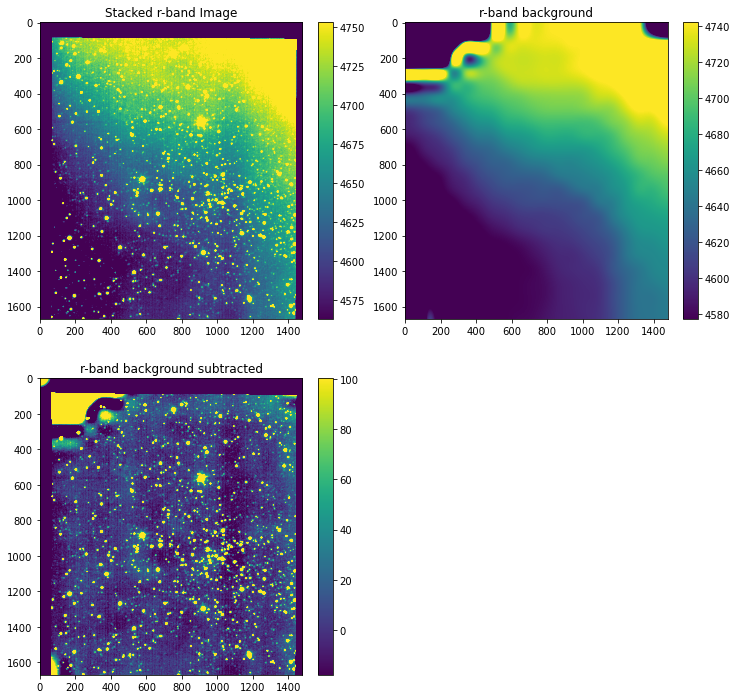

In [21]:
#%%time
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=.2)
plt.subplot(2,2,1)
display_image(routimage_filename_cl,p1=20,p2=90)
plt.colorbar(fraction=.08)
plt.title('Stacked r-band Image')
plt.subplot(2,2,2)
display_image(routimage_filename_bkg,p1=20,p2=90)
plt.colorbar(fraction=.08)
plt.title('r-band background')
plt.subplot(2,2,3)
display_image(routimage_filename_bkgsub,p1=25,p2=95)
plt.colorbar(fraction=.08)
plt.title('r-band background subtracted')

#display_image(goutimage_filename_cl, p1=20,p2=90)

## Problem 3: Describe your final background subtracted images

Open your two stacked and two background subtracted images in DS9.  In the cell below, comment on the features of the combined images with respect to the individual images and on the background subtracted images with respect to the original combined images.  Touch on some of the following points:  
* How do the absolute number of counts compare between the three sets of images in each band?

* How does the noise compare between them?  

* Can you see more, the same, or less stars in the combined image than in the individual images?  How about when you compare the combined to the background subtracted images?  If you see different amounts of stars, comment on which stars you can see (or not) in the combined image.

* How are the cosmicrays different between the individual and combined images?

* Comment on any other differences.

**answer here**

For the individual images, the counts for the background are around 4000 to 5000, similarly to the combined images. But the count on background for the background-substracted image is averaged on 0. The noise is the highest in each individual image, and get better on the combined image. On the background-substracted image, the noise is the lowest. When zoom in to a smaller region on the images, it is very clear that the dimmer stars look brighter on the combined image, and ever more brighter on the background-substracted image. Thus, I can see the most star on the background-substracted image. For example, on the combined image, even though the figure shows a star like spot on the image, the value is pretty close to the background value on the pixels; thus, it is hard to tell if that is a star or not. However, on the background-substracted image, the same star can have 200 value on the pixel value, when its surrounding space only have, on average, 0 value. Thus, I am more confident to tell that is a star when looking at the latter image. 